In [1]:
%pylab inline
figsize(8, 6)

Populating the interactive namespace from numpy and matplotlib


## Import

In [2]:
import pandas
import numpy
from folding_group import FoldingGroupClassifier
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
from utils import get_N_B_events, get_events_number, get_events_statistics

## Reading initial data

In [4]:
import root_numpy
data_nan = pandas.DataFrame(root_numpy.root2array('datasets/tracks.root', 'tracks'))

In [5]:
data_nan.head()

,index,run,event,Bmass,i,mult,partP,partPt,ptB,IPs,...,proj,ID,veloch,signB,signTrack,Dist_phi,N_sig_sw,mu_cut,e_cut,K_cut
0,0,115839,204997902,5.309576,0,13,3.67156,0.300418,4.004197,0.816143,...,1.058442,-211,0.911645,1,-1,0.114615,0.59521,0,0,0
1,1,115839,204997902,5.309576,1,13,8.33952,1.103876,4.004197,1.375382,...,3.121358,-211,0.796731,1,-1,0.051334,0.59521,0,0,0
2,2,115839,204997902,5.309576,2,13,8.37654,1.182519,4.004197,4.338812,...,10.585135,-211,0.946629,1,-1,1.856516,0.59521,0,0,0
3,3,115839,204997902,5.309576,3,13,25.72961,0.905010,4.004197,2.287509,...,7.485243,211,1.058989,1,1,0.577419,0.59521,0,0,0
4,4,115839,204997902,5.309576,4,13,3.70597,0.516123,4.004197,0.562424,...,5.617354,211,1.042135,1,1,1.314513,0.59521,0,0,0


In [6]:
event_id_column = 'event_id'
event_id = data_nan.run.apply(str) + '_' + data_nan.event.apply(str)
data_nan['group_column'] = numpy.unique(event_id, return_inverse=True)[1]
data_nan[event_id_column] = event_id

In [7]:
get_events_statistics(data_nan)

{'Events': 1005757, 'tracks': 27156193}

In [8]:
get_N_B_events()

742867.7142562866

## Remove rows with NAN from data

In [9]:
data = data_nan.dropna()
len(data_nan), len(data), get_events_statistics(data)

(27156193, 27156190, {'Events': 1005757, 'tracks': 27156190})

## Add diff_pt and cos(diff_phi)

In [10]:
# add different between max pt in event and pt for each track
def add_diff_pt(data):
    max_pt = group_max(data[event_id_column].values.astype(str), data.partPt.values)
    data.loc[:, 'diff_pt'] = max_pt - data['partPt'].values

# max is computing max over tracks in the same event for saome data
def group_max(groups, data):
    # computing unique integer id for each group
    assert len(groups) == len(data)
    _, event_id = numpy.unique(groups, return_inverse=True)
    max_over_event = numpy.zeros(max(event_id) + 1) - numpy.inf
    numpy.maximum.at(max_over_event, event_id, data)
    return max_over_event[event_id]

In [11]:
# add diff pt
add_diff_pt(data)
# add cos(diff_phi)
data.loc[:, 'cos_diff_phi'] = numpy.cos(data.diff_phi.values)

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Add max, sum among PIDs

In [12]:
from itertools import combinations
PIDs = {'k': data.PIDNNk.values,
        'e': data.PIDNNe.values,
        'mu': data.PIDNNm.values,
       }
for (pid_name1, pid_values1), (pid_name2, pid_values2) in combinations(PIDs.items(), 2):
    data.loc[:, 'max_PID_{}_{}'.format(pid_name1, pid_name2)] = numpy.maximum(pid_values1, pid_values2)
    data.loc[:, 'sum_PID_{}_{}'.format(pid_name1, pid_name2)] = pid_values1 + pid_values2

## define `label` = `signB` * `signTrack`

* if > 0 (same sign) - label **1**
* if < 0 (different sign) - label **0**

In [13]:
data.loc[:, 'label'] = (data.signB.values * data.signTrack.values > 0) * 1

In [14]:
', '.join(data.columns)

'index, run, event, Bmass, i, mult, partP, partPt, ptB, IPs, IP, IPerr, partlcs, EOverP, ghostProb, IPPU, nnkrec, PIDNNk, PIDNNpi, PIDNNp, PIDNNm, PIDNNe, diff_eta, diff_phi, phi, eta, proj, ID, veloch, signB, signTrack, Dist_phi, N_sig_sw, mu_cut, e_cut, K_cut, group_column, event_id, diff_pt, cos_diff_phi, max_PID_mu_k, sum_PID_mu_k, max_PID_mu_e, sum_PID_mu_e, max_PID_k_e, sum_PID_k_e, label'

## Apply ghost prob cut

In [15]:
initial_cut = '(ghostProb < 0.4)'
data = data.query(initial_cut)

In [16]:
get_events_statistics(data)

{'Events': 1005751, 'tracks': 25567912}

## Leave not muons, kaons, electrons, protons, pions

In [17]:
threshold_kaon = 0.
threshold_muon = 0.
threshold_electron = 0.
threshold_pion = 0.
threshold_proton = 0.
cut_pid = " ( (PIDNNk > {trk}) | (PIDNNm > {trm}) | (PIDNNe > {tre}) | (PIDNNpi > {trpi}) | (PIDNNp > {trp})) "
cut_pid = cut_pid.format(trk=threshold_kaon, trm=threshold_muon, tre=threshold_electron, trpi=threshold_pion, 
                         trp=threshold_proton)
    
data = data.query(cut_pid)

In [18]:
get_events_statistics(data)

{'Events': 1005751, 'tracks': 25531030}

## Calculating tagging efficiency ($\epsilon_{tag}$)

$$N (\text{passed selection}) = \sum_{\text{passed selection}} sw_i$$

$$N (\text{all events}) = \sum_{\text{all events}} sw_i,$$

where $sw_i$ - sPLot weight (sWeight for signal)

$$\epsilon_{tag} = \frac{N (\text{passed selection})} {N (\text{all events})}$$

$$\Delta\epsilon_{tag} = \frac{\sqrt{N (\text{passed selection})}} {N (\text{all events})}$$

In [19]:
N_B_passed = float(get_events_number(data))
tagging_efficiency = N_B_passed / get_N_B_events()
tagging_efficiency_delta = sqrt(N_B_passed) / get_N_B_events()
tagging_efficiency, tagging_efficiency_delta

(0.9998594749632361, 0.0011601489232199002)

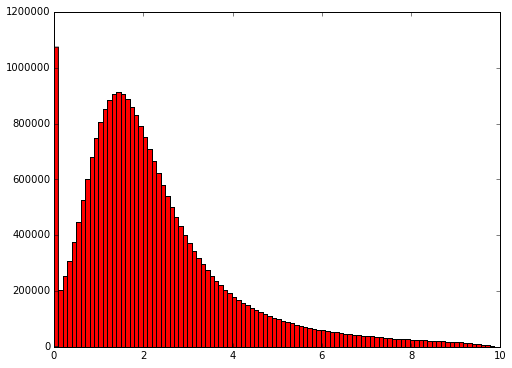

In [20]:
hist(data.diff_pt.values, bins=100)
pass

## Choose most probable B-events

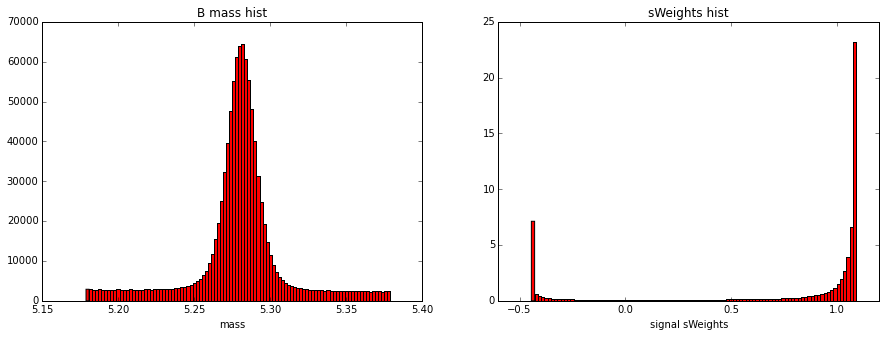

In [21]:
_, take_indices = numpy.unique(data[event_id_column], return_index=True)

figure(figsize=[15, 5])

subplot(1, 2, 1)
hist(data.Bmass.values[take_indices], bins=100)
title('B mass hist')
xlabel('mass')

subplot(1, 2, 2)
hist(data.N_sig_sw.values[take_indices], bins=100, normed=True)
title('sWeights hist')
xlabel('signal sWeights')
#plt.savefig('img/Bmass_less_PID.png' , format='png')

### Define B-like events for training 

Events with low sWeight still will be used only to test quality.

In [22]:
sweight_threshold = 1.
data_sw_passed = data[data.N_sig_sw > sweight_threshold]
data_sw_not_passed = data[data.N_sig_sw <= sweight_threshold]
get_events_statistics(data_sw_passed)

{'Events': 614418, 'tracks': 15266383}

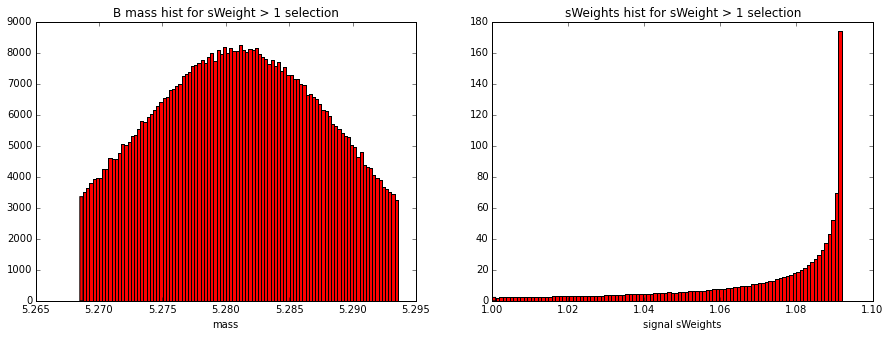

In [23]:
_, take_indices = numpy.unique(data_sw_passed[event_id_column], return_index=True)

figure(figsize=[15, 5])
subplot(1, 2, 1)
hist(data_sw_passed.Bmass.values[take_indices], bins=100)
title('B mass hist for sWeight > 1 selection')
xlabel('mass')

subplot(1, 2, 2)
hist(data_sw_passed.N_sig_sw.values[take_indices], bins=100, normed=True)
title('sWeights hist for sWeight > 1 selection')
xlabel('signal sWeights')
# plt.savefig('img/Bmass_selected_less_PID.png' , format='png')

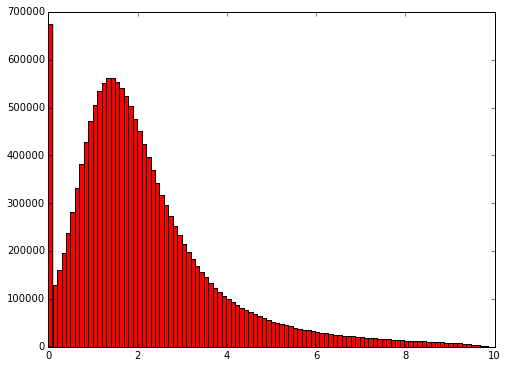

In [24]:
hist(data_sw_passed.diff_pt.values, bins=100)
pass

# Main idea: 
## find tracks, which can help reconstruct the sign of B if you know track sign.

`label` = `signB` * `signTrack`
* the highest output means that this is same sign B as track
* the lowest output means that this is opposite sign B than track

## Define features

In [25]:
features = list(set(data.columns) - {'index', 'run', 'event', 'i', 'signB', 'N_sig_sw', 'Bmass', 'mult', 
                                     'PIDNNp', 'PIDNNpi', 'label', 'thetaMin', 'Dist_phi', event_id_column, 
                                     'mu_cut', 'e_cut', 'K_cut', 'ID', 'diff_phi', 'group_column'})
features

['cos_diff_phi',
 'diff_pt',
 'partPt',
 'partP',
 'signTrack',
 'nnkrec',
 'diff_eta',
 'EOverP',
 'ptB',
 'sum_PID_mu_k',
 'proj',
 'PIDNNe',
 'sum_PID_k_e',
 'PIDNNk',
 'sum_PID_mu_e',
 'PIDNNm',
 'phi',
 'IP',
 'IPerr',
 'IPs',
 'veloch',
 'max_PID_k_e',
 'ghostProb',
 'IPPU',
 'eta',
 'max_PID_mu_e',
 'max_PID_mu_k',
 'partlcs']

## PID pairs scatters

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


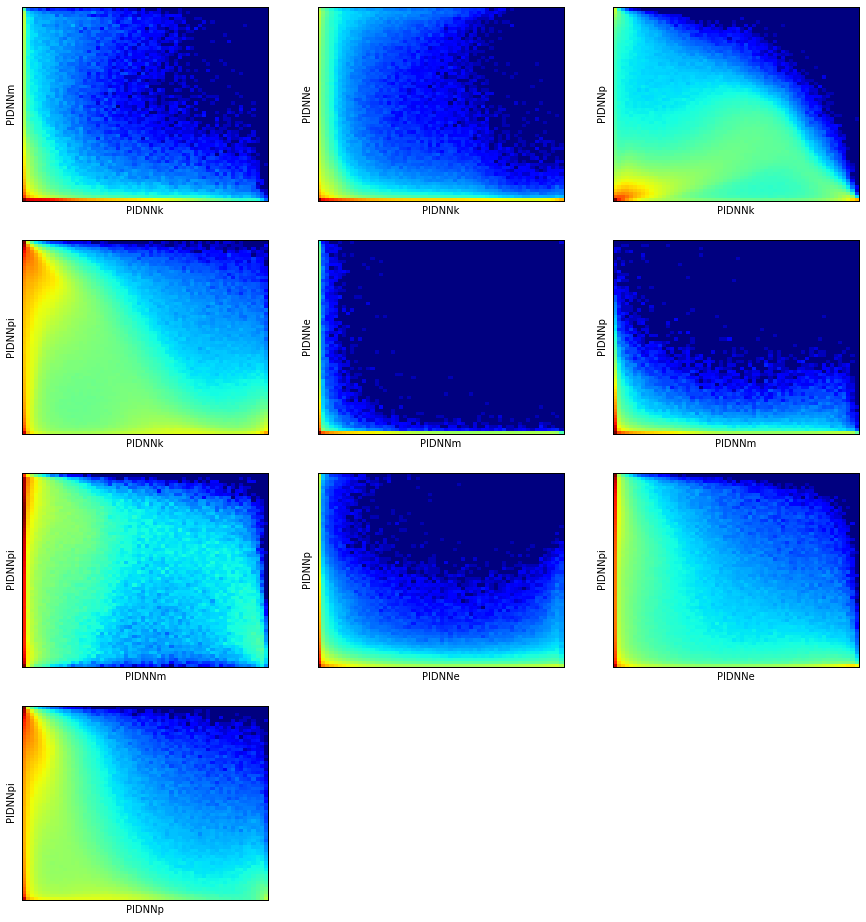

In [26]:
figure(figsize=[15, 16])
bins = 60
step = 3
for i, (feature1, feature2) in enumerate(combinations(['PIDNNk', 'PIDNNm', 'PIDNNe', 'PIDNNp', 'PIDNNpi'], 2)):
    subplot(4, 3, i + 1)
    Z, (x, y) = numpy.histogramdd(data_sw_passed[[feature1, feature2]].values, bins=bins, range=([0, 1], [0, 1]))
    pcolor(numpy.log(Z).T, vmin=0)
    xlabel(feature1)
    ylabel(feature2)
    xticks(numpy.arange(bins, step), x[::step]), yticks(numpy.arange(bins, step), y[::step])
# plt.savefig('img/PID_selected_less_PID.png' , format='png')

## pt

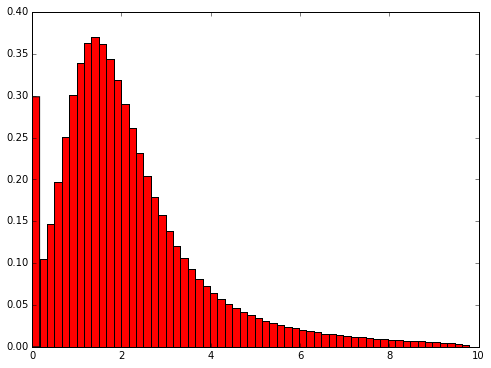

In [27]:
hist(data_sw_passed.diff_pt.values, bins=60, normed=True)
pass

## count of tracks

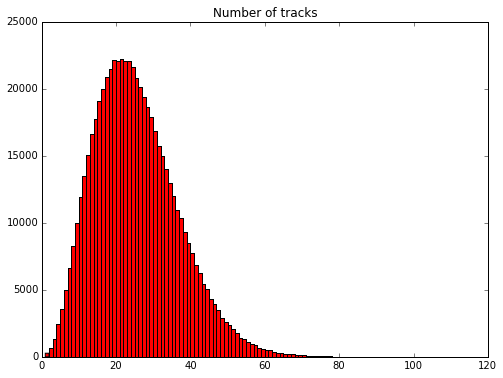

In [28]:
_, n_tracks = numpy.unique(data_sw_passed[event_id_column], return_counts=True)
hist(n_tracks, bins=100)    
title('Number of tracks')
# plt.savefig('img/tracks_number_less_PID.png' , format='png')

## PIDs histograms

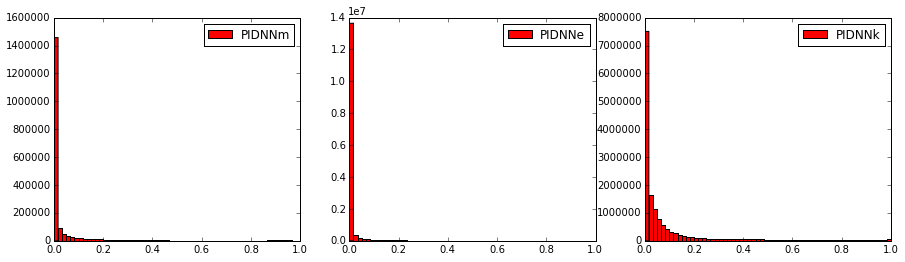

In [29]:
figure(figsize=[15, 4])
for i, column in enumerate(['PIDNNm', 'PIDNNe', 'PIDNNk']):
    subplot(1, 3, i + 1)
    hist(data_sw_passed[column].values, bins=60, range=(0, 1), label=column)
    legend()

----

## Train to distinguish same sign vs opposite sign

In [30]:
from hep_ml.decisiontrain import DecisionTrainClassifier
from hep_ml.losses import LogLossFunction
from rep.estimators import SklearnClassifier

In [31]:
data_sw_passed_lds = LabeledDataStorage(data_sw_passed, data_sw_passed.label, data_sw_passed.N_sig_sw.values)

### DT

In [40]:
from rep.estimators import XGBoostClassifier

In [52]:
xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.01, nthreads=12, 
                             subsample=0.1, max_depth=6)
xgb_folding = FoldingGroupClassifier(xgb_base, n_folds=2, random_state=11, 
                                    train_features=features, group_feature='group_column')
%time xgb_folding.fit_lds(data_sw_passed_lds)
pass

CPU times: user 9h 14min 55s, sys: 49.4 s, total: 9h 15min 44s
Wall time: 1h 11min 8s


In [53]:
comparison_report = ClassificationReport({'tt': xgb_folding}, data_sw_passed_lds)

KFold prediction using folds column


In [54]:
comparison_report.compute_metric(RocAuc())

OrderedDict([('tt', 0.51625535990196525)])

In [56]:
lc = comparison_report.learning_curve(RocAuc(), steps=1)

KFold prediction using folds column


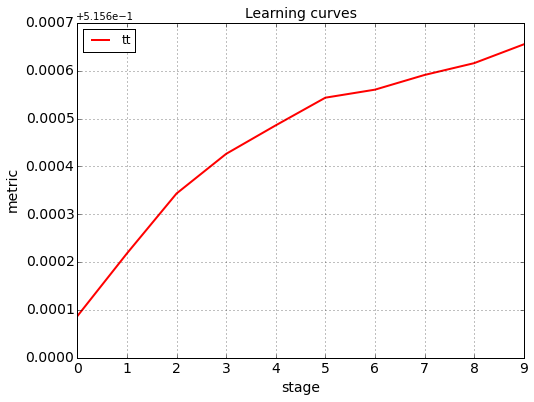

In [57]:
lc

In [ ]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=3000, depth=6, pretransform_needed=True, 
                                  max_features=15, loss=LogLossFunction(regularization=100), n_threads=8)
tt_folding = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                    train_features=features, group_feature='group_column')
%time tt_folding.fit_lds(data_sw_passed_lds)
pass

In [ ]:
import cPickle
with open('models/dt_full_group_sign.pkl', 'w') as f:
    cPickle.dump(tt_folding, f)

In [ ]:
comparison_report = ClassificationReport({'tt': tt_folding}, data_sw_passed_lds)

In [44]:
comparison_report.compute_metric(RocAuc())

OrderedDict([('tt', 0.51606697274145841)])

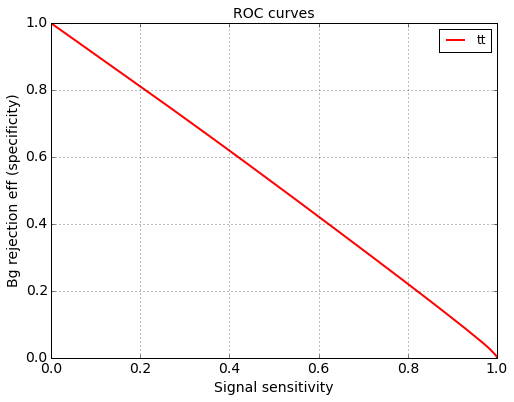

In [45]:
comparison_report.roc()

In [41]:
lc = comparison_report.learning_curve(RocAuc(), steps=1)

KFold prediction using folds column


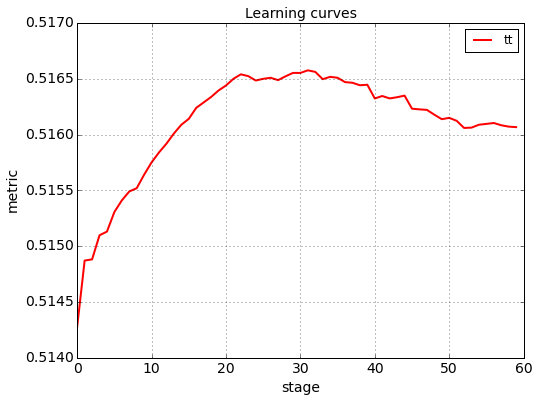

In [42]:
lc

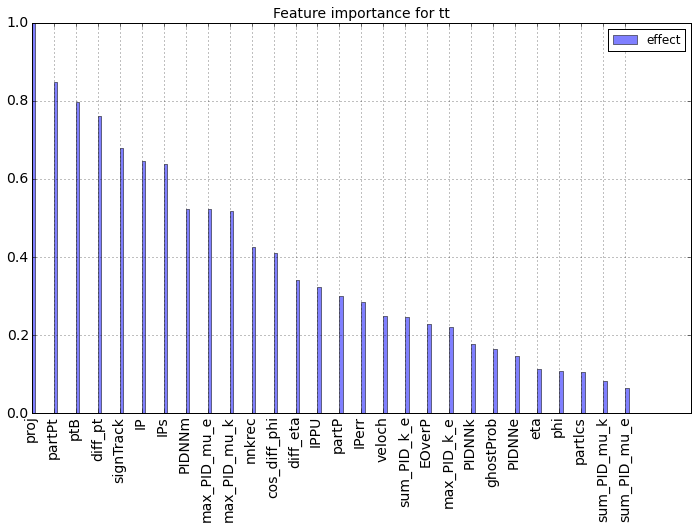

In [43]:
comparison_report.feature_importance()

---------

# Calibration

In [46]:
from utils import get_result_with_bootstrap_for_given_part

In [47]:
models = []

In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'tt-iso', logistic=False))

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)

In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'tt-log', logistic=True))

In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'tt-iso-normed', 
                                                       logistic=False, normed_signs=True))

In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'tt-log-normed', 
                                                       logistic=True, normed_signs=True))

## Comparison table of different models

In [52]:
pandas.set_option('display.precision', 8)
result = pandas.concat(models)
result.index = result.name
result.drop('name', axis=1)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
name,,,,,,,,
tt-iso,99.9859475,0.11601489,0.03570645,0.00038309,3.57014302,0.03852717,61.12289339,0
tt-log,99.9859475,0.11601489,0.02889894,0.00053599,2.88948829,0.05369602,60.11051977,0
tt-iso-normed,99.9859475,0.11601489,0.03080938,0.00033487,3.08050473,0.03367237,60.42195878,0
tt-log-normed,99.9859475,0.11601489,0.02465840,0.00030238,2.46549355,0.03036853,59.50229088,0


--------------------------